## Testing transforms.py

In [350]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# This file contains all the main external libs we'll use
from fastai.imports import *
from fastai.transforms import *
from fastai.plots import *
from fastai.dataset import *

In [351]:
PATH = "data/fish/"
PATH = "/data2/yinterian/fisheries-kaggle/"
PATH = '../../data/fish/'

### Download Fish Annotations

In [352]:
#Download Annotations
from keras.utils.data_utils import get_file

def get_annotations(path='../../data/fish'):
    annot_urls = {
        '5458/bet_labels.json': 'bd20591439b650f44b36b72a98d3ce27',
        '5459/shark_labels.json': '94b1b3110ca58ff4788fb659eda7da90',
        '5460/dol_labels.json': '91a25d29a29b7e8b8d7a8770355993de',
        '5461/yft_labels.json': '9ef63caad8f076457d48a21986d81ddc',
        '5462/alb_labels.json': '731c74d347748b5272042f0661dad37c',
        '5463/lag_labels.json': '92d75d9218c3333ac31d74125f2b380a'
    }
    cache_subdir = os.path.abspath(os.path.join(path, 'annos'))
    url_prefix = 'https://kaggle2.blob.core.windows.net/forum-message-attachments/147157/'
    
    if not os.path.exists(cache_subdir):
        os.makedirs(cache_subdir)
    
    for url_suffix, md5_hash in annot_urls.items():
        fname = url_suffix.rsplit('/', 1)[-1]
        get_file(fname, url_prefix + url_suffix, cache_subdir=cache_subdir, md5_hash=md5_hash)
        
get_annotations()

In [353]:
#Consolidate json file labels
anno_classes = ['alb', 'bet', 'dol', 'lag', 'other', 'shark', 'yft']
bb_json = {}
for c in anno_classes:
    if c == 'other': continue # no annotation file for "other" class
    j = json.load(open('{}annos/{}_labels.json'.format(PATH, c), 'r'))
    for l in j:
        if 'annotations' in l.keys() and len(l['annotations'])>0:
            bb_json[l['filename'].split('/')[-1]] = sorted(
                l['annotations'], key=lambda x: x['height']*x['width'])[-1]

#Only need coordinates. Convert to format
#For parse_csv_labels which excpets tuple => (fname, data)
bb_df = pd.DataFrame.from_dict(bb_json).T
bb_df['x_prime'] = bb_df['x'] +  bb_df['width']
bb_df['y_prime'] = bb_df['y'] +  bb_df['height']
bb_df = bb_df.astype(str)
bb_df['parse_labels'] = bb_df['y'] + ' ' + bb_df['x'] + ' ' + bb_df['y_prime'] + ' ' + bb_df['x_prime']
bb_df[['parse_labels']].to_csv('{}annos/trn_bb_corners_labels.csv'.format(PATH))

### Fish with bounding box

In [354]:
fnames,corner_labels,_,_ = parse_csv_labels('{}/{}/trn_bb_corners_labels.csv'.format(PATH, 'annos'), skip_header=True)

In [355]:
def get_x(f):
    im = glob('{}train/*/{}'.format(PATH, f))[0]
    return open_image(im)

In [356]:
f = 'img_02642.jpg'
x = get_x(f)
y = np.array(corner_labels[f], dtype=np.float32)
y

array([ 699.39874,  954.6971 ,  895.3254 , 1275.3043 ], dtype=float32)

In [357]:
x.shape

(974, 1280, 3)

In [358]:
rows = np.rint([y[0], y[0], y[2], y[2]]).astype(int)
rows

array([699, 699, 895, 895])

In [359]:
cols = np.rint([y[1], y[3], y[1], y[3]]).astype(int)
cols

array([ 955, 1275,  955, 1275])

In [360]:
corner_labels["img_02642.jpg"]

['699.3987489265355',
 '954.6971037978516',
 '895.3253933626618',
 '1275.3043401478762']

In [361]:
def create_corner_rect(bb, color='red'):
    bb = np.array(bb, dtype=np.float32)
    return plt.Rectangle((bb[1], bb[0]), bb[3]-bb[1], bb[2]-bb[0], color=color, fill=False, lw=3)

def show_corner_bb(f='img_04908.jpg'):
    file_path = glob('{}train/*/{}'.format(PATH, f))[0]
    bb = corner_labels[f]
    plots_from_files([file_path])
    plt.gca().add_patch(create_corner_rect(bb))

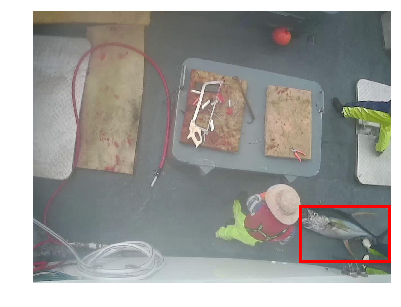

In [362]:
show_corner_bb(f = 'img_02642.jpg')

In [363]:
def create_rect(bb, color='red'):
    return plt.Rectangle((bb[1], bb[0]), bb[3]-bb[1], bb[2]-bb[0], color=color, fill=False, lw=3)

def plotXY(x,y):
    plots([x])
    plt.gca().add_patch(create_rect(y))

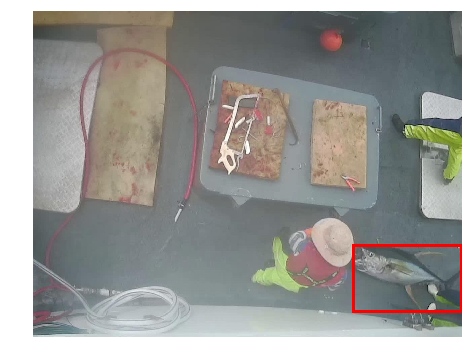

In [364]:
plotXY(x,y)

## Scale

In [365]:
xx, yy = Scale(sz=350, tfm_y=TfmType.COORD)(x, y)

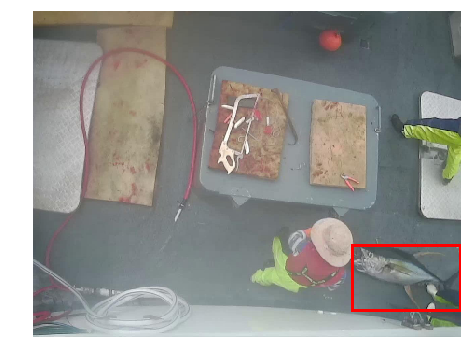

In [366]:
plotXY(xx,yy)

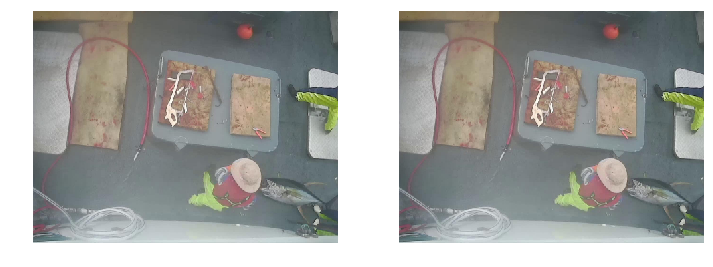

In [367]:
xx, yy = Scale(sz=350, tfm_y=TfmType.PIXEL)(x, x)
plots([xx, yy])

## RandomScale

[259 353 259 472]
[ 699.39874  954.6971   895.3254  1275.3043 ]


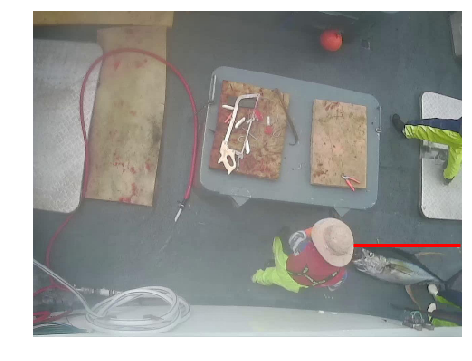

In [368]:
#TODO: Appears to be a bug in RandomScale for bounding box
xx, yy = RandomScale(sz=350, max_zoom=1.1, tfm_y=TfmType.COORD)(x, y)
plotXY(xx,yy)
print(yy)
print(y)

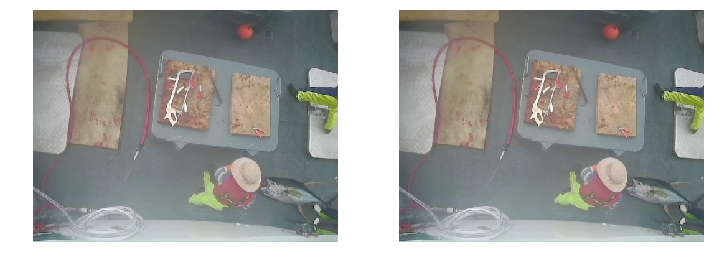

In [204]:
xx, yy = RandomScale(sz=350, max_zoom=1.1, tfm_y=TfmType.PIXEL)(x, x)
plots([xx, yy])

## RandomCrop

In [399]:
#TODO: Bounding box might be problematic here too.
xx, yy = RandomCrop(targ=350, tfm_y=TfmType.COORD)(x, y)

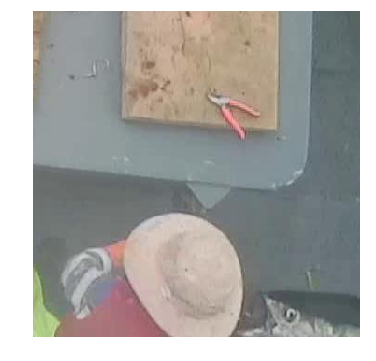

In [400]:
plotXY(xx,yy)

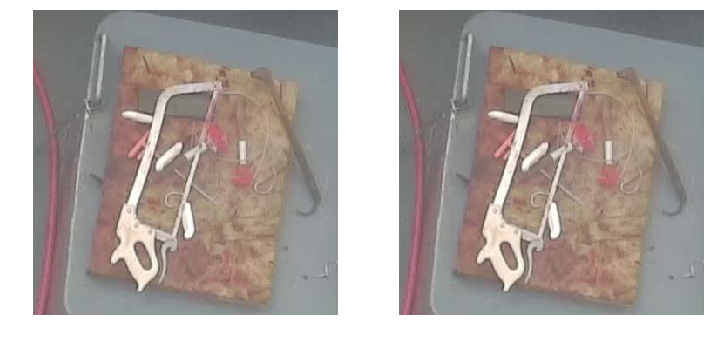

In [402]:
xx, yy = RandomCrop(350, tfm_y=TfmType.PIXEL)(x, x)
plots([xx, yy])

## No Cropping

In [403]:
xx, yy = NoCrop(350, tfm_y=TfmType.COORD)(x, y)

[251 261 321 348]


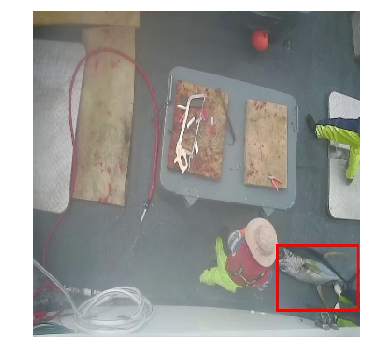

In [404]:
print(yy)
plotXY(xx,yy)

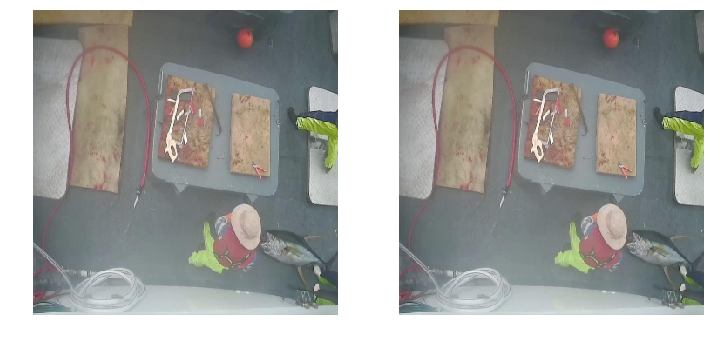

In [405]:
xx, yy = NoCrop(350, tfm_y=TfmType.PIXEL)(x, x)
plots([xx, yy])

## CenterCrop

In [409]:
xx, yy = CenterCrop(350, tfm_y=TfmType.COORD)(x, y)

loss my fish


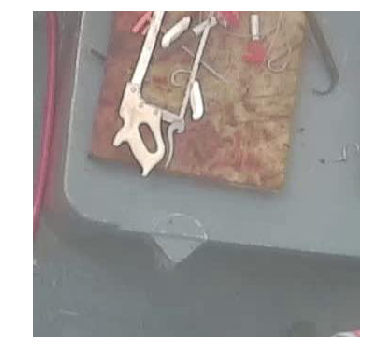

In [410]:
plotXY(xx,yy)

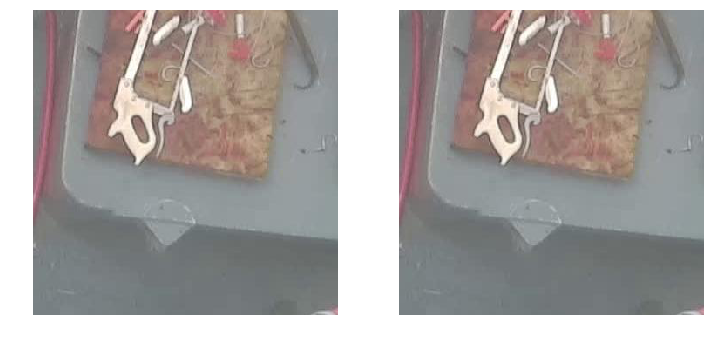

In [411]:
xx, yy = CenterCrop(350, tfm_y=TfmType.PIXEL)(x, x)
plots([xx, yy])

## Random Dihedral

In [412]:
xx, yy = RandomDihedral(TfmType.COORD)(x, y)

In [413]:
print(yy)

[  78  955  274 1275]


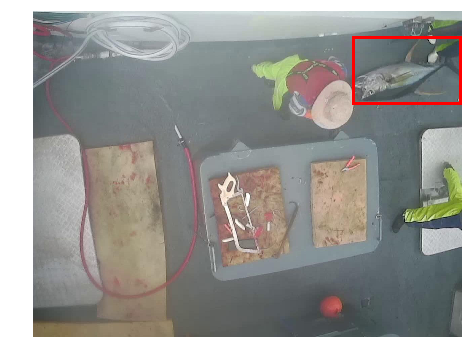

In [415]:
plotXY(xx,yy)

In [416]:
xx, yy = RandomDihedral(tfm_y=TfmType.PIXEL)(x, x)

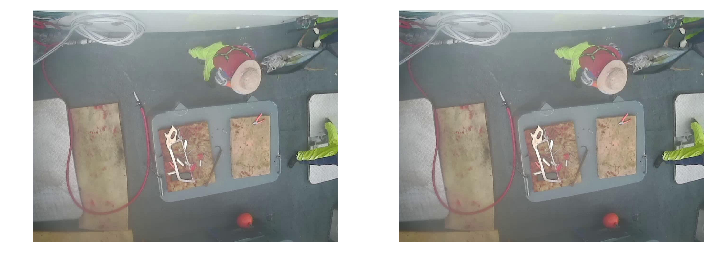

In [417]:
plots([xx,yy])

## RandomFlipXY

[699   4 895 324]


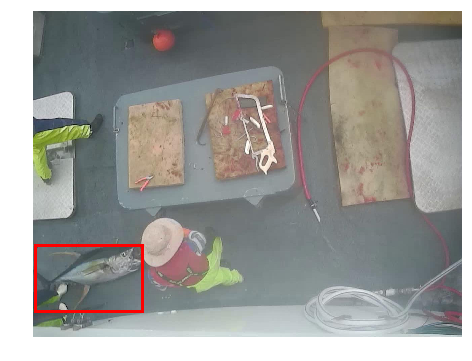

In [419]:
xx, yy = RandomFlip(TfmType.COORD)(x, y)
print(yy)
plotXY(xx,yy)

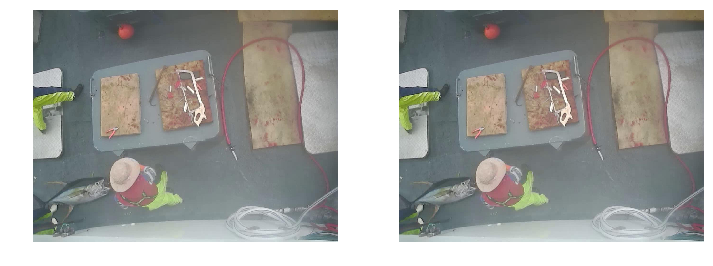

In [420]:
xx, yy = RandomFlip(TfmType.PIXEL)(x, x)
plots([xx,yy])

## RandomLightingXY (talk to Jeremy about this)

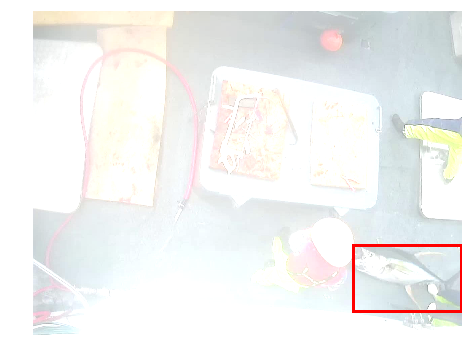

In [421]:
xx, yy = RandomLighting(0.5, 0.5)(x, y)
plotXY(xx,yy)

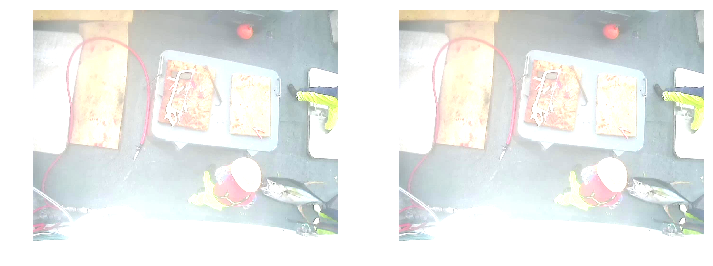

In [422]:
# talk to Jeremy about this
xx, yy = RandomLighting(0.5, 0.5, TfmType.PIXEL)(x, x)
plots([xx,yy])

## RandomRotate

[ 396 1016  707 1279]


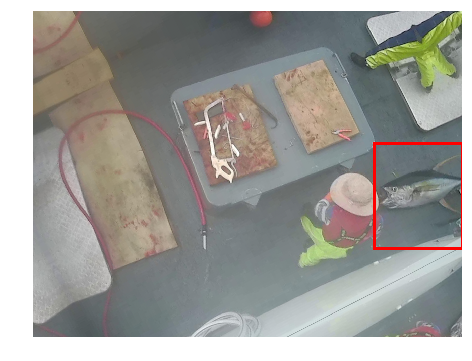

In [424]:
xx, yy = RandomRotate(deg=30, p=1, tfm_y=TfmType.COORD)(x, y)
plotXY(xx,yy)
print(yy)

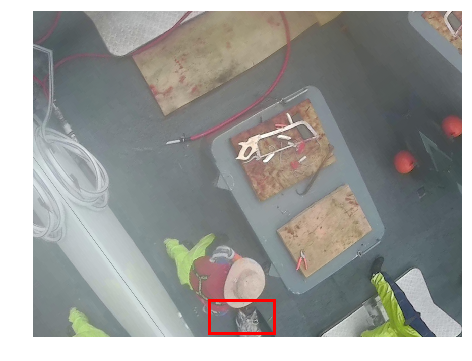

In [425]:
xx, yy = RandomRotate(130,p=1.0, tfm_y=TfmType.COORD)(x, y)
plotXY(xx,yy)

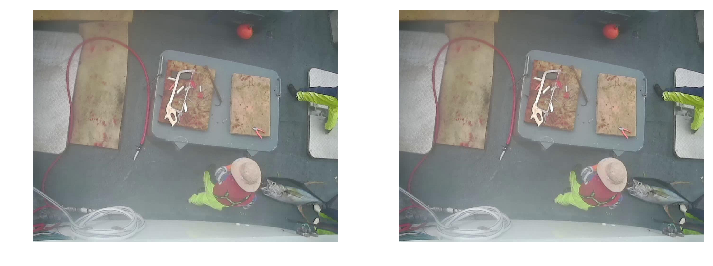

In [426]:
xx, yy = RandomRotate(0.5, 0.5, TfmType.PIXEL)(x, x)
plots([xx,yy])

## RandomRotateZoom

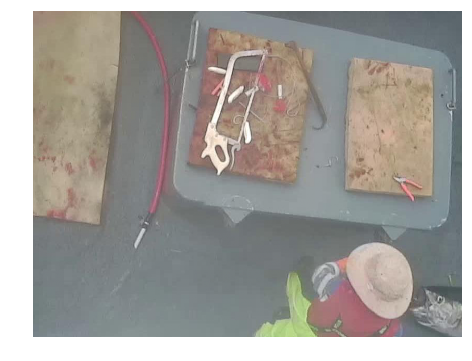

In [427]:
#TODO: Should take in bounding box.
xx = RandomRotateZoom(30, 1.1, 1.5)(x, None)
plots([xx])

## Miscellaneous Testing

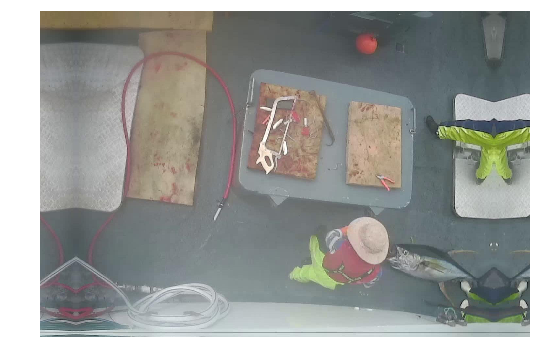

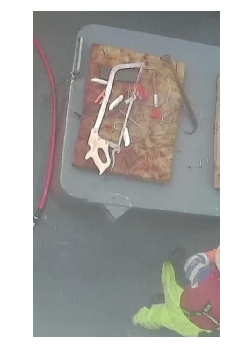

In [428]:
xx = padding_resize_cv(x, 1000, 1500)
xx_ = padding_resize_cv(x, 700, 400)
plots([xx])
plots([xx_])

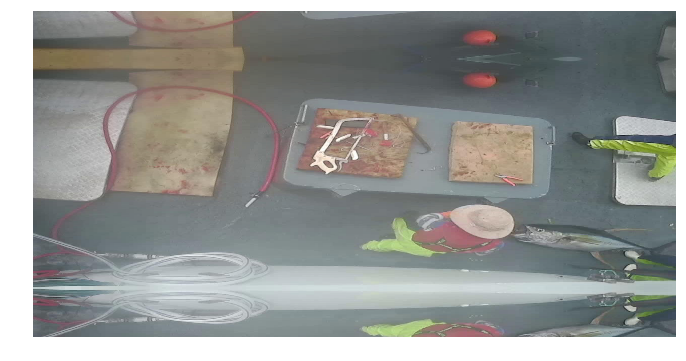

In [429]:
xx = stretch_cv(x, 1.5, 0.7)
plots([xx])